# Russian - Solution Lesson 7 on Fast.ai
> Abbreviated solution of the lesson 7 on fast.ai

- toc: true
- branch: master
- badges: true
- comments: true
- author: Zmey56
- categories: [russian, fast.ai, solution]

In [1]:
#hide
from fastbook import *

# Обучение соверменных моделей 

В этой главе представлены более продвинутые методы обучения модели классификации изображений и получения самых современных результатов. Вы можете пропустить его, если хотите узнать больше о других приложениях глубокого обучения и вернуться к нему позже—знание этого материала не будет предполагаться в последующих главах.

Мы рассмотрим, что такое нормализация, мощный метод увеличения данных, называемый mixup, прогрессивный подход к изменению размера и увеличение времени тестирования. Чтобы показать все это, мы собираемся обучить модель с нуля (не используя трансферное обучение), используя подмножество ImageNet, называемое Imagenette. Он содержит подмножество из 10 очень разных категорий из исходного набора данных ImageNet, что позволяет быстрее обучаться, когда мы хотим поэкспериментировать.

Это будет намного сложнее сделать хорошо, чем с нашими предыдущими наборами данных, потому что мы используем полноразмерные, полноцветные изображения, которые представляют собой фотографии объектов разных размеров, в разных ориентациях, при различном освещении и так далее. Итак, в этой главе мы познакомим вас с некоторыми важными методами получения максимальной отдачи от вашего набора данных, особенно когда вы тренируетесь с нуля или используете трансферное обучение для обучения модели на совершенно ином типе набора данных, чем используемая предварительно обученная модель.

## Imagenette

Когда fast.ai создавали, было три основных набора данных, которые люди использовали для построения и тестирования моделей компьютерного зрения:

* ImageNet:: 1,3 миллиона изображений различных размеров около 500 пикселей в поперечнике, в 1000 категориях, обучение которым заняло несколько дней
* MNIST:: 50 000 28×28-пиксельных оттенков серого рукописных цифр
* CIFAR10:: 60 000 32×32-пиксельных цветных изображений в 10 классах

Проблема заключалась в том, что меньшие наборы данных на самом деле не были обобщены на самом деле на большом наборе данных ImageNet. Подходы, которые хорошо работали в ImageNet, как правило, должны были бы быть разработаны и обучены в ImageNet. Это привело к тому, что многие люди поверили, что только исследователи, имеющие доступ к гигантским вычислительным ресурсам, могут эффективно участвовать в разработке алгоритмов классификации изображений.

Мы думали, что это маловероятно похоже на правду. Мы решили попытаться создать новый набор данных, на котором исследователи могли бы быстро и дешево протестировать свои алгоритмы, но который также дал бы представление о том, как работать с полным набором данных ImageNet.

Примерно через три часа мы создали Imagenette. Мы выбрали 10 классов из полного ImageNet, которые выглядели очень непохожими друг на друга. Как мы и надеялись, нам удалось быстро и дешево создать классификатор, способный распознавать эти классы. Затем мы опробовали несколько алгоритмических настроек, чтобы увидеть, как они повлияли на Imagenette. Мы нашли некоторые из них, которые работали довольно хорошо, и протестировали их также на ImageNet—и мы были очень рады обнаружить, что наши настройки хорошо работали и на ImageNet!

Здесь есть важное сообщение: набор данных, который вы получаете, не обязательно является тем набором данных, который вы хотите. Особенно маловероятно, что это будет тот набор данных, в котором вы хотите заниматься разработкой и прототипированием. Вы должны стремиться к тому, чтобы скорость итерации составляла не более пары минут—то есть, когда вы придумываете новую идею, которую хотите опробовать, вы должны быть в состоянии обучить модель и посмотреть, как она работает в течение нескольких минут. Если эксперимент занимает больше времени, подумайте о том, как вы могли бы сократить набор данных или упростить модель, чтобы повысить скорость экспериментов. Чем больше экспериментов вы сможете провести, тем лучше!

Давайте начнем с этого набора данных:

In [2]:
from fastai.vision.all import *
path = untar_data(URLs.IMAGENETTE)

Сначала мы поместим наш набор данных в объект Dataloader, используя трюк изменения размера:

In [3]:
dblock = DataBlock(blocks=(ImageBlock(), CategoryBlock()),
                   get_items=get_image_files,
                   get_y=parent_label,
                   item_tfms=Resize(460),
                   batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = dblock.dataloaders(path, bs=64)

и сделайте тренировочный прогон, который послужит основой:

In [4]:
model = xresnet50()
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.604518,1.846823,0.485810,02:07
1,1.251086,1.524415,0.559746,02:08
2,0.986634,0.959455,0.693054,02:09
3,0.733720,0.643728,0.796117,02:09
4,0.591311,0.593129,0.811053,02:09


Это хороший базовый уровень, поскольку мы не используем предварительно подготовленную модель, но мы можем сделать лучше. При работе с моделями, которые обучаются с нуля или настраиваются на совершенно другой набор данных, чем тот, который используется для предварительного обучения, есть некоторые дополнительные методы, которые действительно важны. В оставшейся части главы мы рассмотрим некоторые ключевые подходы, с которыми вы захотите ознакомиться. Первый - это нормализация ваших данных.

## Нормализация

При обучении модели полезно, если ваши входные данные нормализованы—то есть имеют среднее значение 0 и стандартное отклонение 1. Но большинство изображений и библиотек компьютерного зрения используют значения между 0 и 255 для пикселей или между 0 и 1; в любом случае ваши данные не будут иметь среднее значение 0 и стандартное отклонение 1.

Давайте возьмем пакет наших данных и посмотрим на эти значения, усреднив их по всем осям, кроме оси канала, которая является осью 1:

In [5]:
x,y = dls.one_batch()
x.mean(dim=[0,2,3]),x.std(dim=[0,2,3])

(TensorImage([0.4898, 0.4815, 0.4437], device='cuda:0'),
 TensorImage([0.2862, 0.2812, 0.3122], device='cuda:0'))

In [6]:
def get_dls(bs, size):
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_items=get_image_files,
                   get_y=parent_label,
                   item_tfms=Resize(460),
                   batch_tfms=[*aug_transforms(size=size, min_scale=0.75),
                               Normalize.from_stats(*imagenet_stats)])
    return dblock.dataloaders(path, bs=bs)

In [7]:
dls = get_dls(64, 224)

In [8]:
x,y = dls.one_batch()
x.mean(dim=[0,2,3]),x.std(dim=[0,2,3])

(TensorImage([-0.0622, -0.0261,  0.0051], device='cuda:0'),
 TensorImage([1.2568, 1.2598, 1.3187], device='cuda:0'))

Давайте проверим, как это повлияло на обучение нашей модели:

In [9]:
model = xresnet50()
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.738131,2.420559,0.356983,02:10
1,1.275637,1.705510,0.474981,02:10
2,0.963854,1.504349,0.594847,02:10
3,0.729794,0.721336,0.784167,02:09
4,0.617732,0.594153,0.823002,02:09


Хотя здесь это лишь немного помогло, нормализация становится особенно важной при использовании предварительно подготовленных моделей. Предварительно обученная модель умеет работать только с данными того типа, который она использовала ранее. Если среднее значение пикселя было 0 в данных, с которыми она была обучена, но ваши данные имеют 0 как минимально возможное значение пикселя, то модель будет видеть что-то очень отличное от того, для чего расчитана!

Это означает, что при распространении модели необходимо также распространять статистику, используемую для нормализации, поскольку любой, кто использует ее для получения результатов или трансферного обучения, должен будет использовать ту же статистику. Точно так же, если вы используете модель, которую обучил кто-то другой, обязательно выясните, какую статистику нормализации они использовали, и применить ее.

Нам не пришлось работать с нормализацией в предыдущих главах, потому что при использовании предварительно обученной модели через *cnn_learner* библиотека *fastai* автоматически добавляет соответствующее преобразование *Normalize*; модель была предварительно обучена с определенной статистикой в *Normalize*(обычно определяемой из набора данных *ImageNet*), поэтому библиотека может выполнить это для вас. Обратите внимание, что это относится только к предварительно подготовленным моделям, поэтому нам нужно выполнить это вручную при обучении с нуля.

Все наши тренировки до сих пор проводились с размером 224. Дальше рассмотрим прогрессивное изменение размера.

## Прогрессивное изменение размера

Когда одна из команд студентов с помощью *fast.ai* выиграла конкурс DAWNBench в 2018 году, одним из самых важных нововведений было что-то очень простое: начать обучение с использованием маленьких изображений и закончить обучение с использованием больших изображений. Тренировка большей части эпох с маленькими по размеру изображениями помогает завершить их быстрее. А завершение обучения с использованием больших изображений значительно повышает конечную точность. Мы называем этот подход прогрессивным изменением размеров.

> жаргон: прогрессивное изменение размера: постепенное уыеличение размера изображения по мере тренировки.

Как мы уже видели, типы признаков, которые изучаются сверточными нейронными сетями, никоим образом не зависят от размера изображения—ранние слои находят такие вещи, как края и градиенты, а более поздние слои могут находить такие вещи, как носы и закаты солнца. Поэтому, когда мы меняем размер изображения в середине обучения, это не означает, что мы должны перенастроить параметры для нашей модели.

Но очевидно, что есть некоторые различия между маленькими изображениями и большими, поэтому мы не должны ожидать, что наша модель будет продолжать работать точно так же хорошо если не провести каких-либо изменений вообще. Это вам что-то напоминает? Когда мы разработали эту идею, она напомнила нам о трансферном обучении! Мы пытаемся заставить нашу модель научиться делать что-то немного отличное от того, что она научилась делать раньше. Поэтому мы должны иметь возможность использовать метод *fine_tune* после изменения размера наших изображений.

У прогрессивного изменения размера есть еще одно преимущество: это еще одна форма прироста данных. Поэтому вы должны ожидать лучшего обобщения ваших моделей, которые обучаются с прогрессивным изменением размера.

Для реализации прогрессивного изменения размера наиболее удобно, если вы сначала создадите функцию *get_dls*, которая принимает размер изображения и размер пакета, как мы это делали в предыдущем разделе, и возвращает ваш *DataLoaders*:

Теперь вы можете создавать свои *DataLoaders* с небольшим размером и использовать fit_one_cycle обычным способом, тренируясь на несколько меньших эпохах, чем если бы делали это в противном случае:

In [10]:
dls = get_dls(128, 128)
learn = Learner(dls, xresnet50(), loss_func=CrossEntropyLossFlat(), 
                metrics=accuracy)
learn.fit_one_cycle(4, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.875896,1.774017,0.500747,00:53
1,1.293527,1.380599,0.579910,00:54
2,0.956708,0.844871,0.738611,00:53
3,0.735907,0.673869,0.802465,00:53


Затем вы можете заменить DataLoaders внутри Learner и точно настроить их:

In [11]:
learn.dls = get_dls(64, 224)
learn.fine_tune(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.846806,1.325565,0.599328,02:10


epoch,train_loss,valid_loss,accuracy,time
0,0.653103,0.797360,0.766243,02:10
1,0.656540,0.708841,0.784541,02:10
2,0.582353,0.571958,0.827857,02:10
3,0.497656,0.468391,0.854742,02:10
4,0.437954,0.447989,0.861464,02:10


Как вы можете видеть, мы получаем гораздо лучшую производительность, и первоначальное обучение на небольших изображениях было намного быстрее в каждую эпоху.

Вы можете повторить процесс увеличения размера и обучения большего количества эпох столько раз, сколько захотите, для изображения того, какое хотите — но, конечно, вы не получите никакой пользы, используя размер изображения больше, чем размер ваших изображений оригиналов.

Обратите внимание, что для транферного обучения, прогрессивное изменение размера может фактически навредить результативности. Это, скорее всего, произойдет, если ваша предварительно обученная модель была очень похожа на вашу задачу трансферного обучения и набор данных и была обучена на изображениях одинакового размера, поэтому веса не требовали сильного изменения. В этом случае тренировка на меньших изображениях может повредить предварительно натренированные веса.

С другой стороны, если задача трансферного обучения будет использовать изображения разных размеров, форм или стилей, чем те, которые используются в задаче предварительного обучения, прогрессивное изменение размера, вероятно, поможет. Как всегда, ответ на вопрос "Поможет ли это? "звучит так: "Попробуйте!"

Еще одна вещь,которую мы могли бы попробовать, - это применить увеличение данных к набору проверки. До сих пор мы применяли его только на обучающем наборе; набор проверки всегда получает одни и те же изображения. Но, возможно, мы могли бы попытаться сделать прогнозы для нескольких расширенных версий набора проверки и усреднить их. Далее мы рассмотрим этот подход.

## Аугментация во время теста

Мы использовали случайное кадрирование (обрезку) как способ получить некоторый полезный прирост данных, что приводит к лучшему обобщению и требует меньшего количества обучающих данных. Когда мы используем случайную обрезку, fastai автоматически использует центральную обрезку для набора проверки-то есть он выберет самую большую квадратную область в центре изображения, не выходя за края изображения.

Это часто может быть проблематично. Например, в наборе данных с несколькими метками иногда есть небольшие объекты по краям изображения; они могут быть полностью обрезаны путем обрезки по центру. Даже для таких проблем, как наш пример классификации пород домашних животных, возможно, что некоторые критические признаки, необходимые для идентификации правильной породы, такие как цвет носа, могут быть обрезаны.

Одно из решений этой проблемы состоит в том, чтобы полностью избежать случайной обрезки. Вместо этого мы могли бы просто сжать или растянуть прямоугольные изображения, чтобы они поместились в квадратное пространство. Но тогда мы упускаем очень полезное увеличение данных, а также усложняем распознавание изображений для нашей модели, потому что она должна научиться распознавать сдавленные и сжатые изображения, а не просто правильно пропорциональные изображения.

Другое решение состоит в том, чтобы не просто центрировать кадрирование для проверки, а вместо этого выбрать несколько областей для кадрирования из исходного прямоугольного изображения, пропустить каждую из них через нашу модель и взять максимум или среднее значение прогнозов. Фактически, мы могли бы сделать это не только для разных кадрирований, но и для разных значений всех наших параметров приращением во время тестирования. Это известно как приращение во время тестирования (Test Time Augmentation - TTA).

> жаргон: приращение во время тестирования( TTA): во время вывода или проверки создается несколько версий каждого изображения, используя приращение данных, а затем берется среднее или максимальное значение прогнозов для каждой расширенной версии изображения.

В зависимости от набора данных приращение во время тестирования может привести к значительному повышению точности. Это не изменит время, необходимое для обучения в общем, но увеличит количество времени, необходимого для проверки или вывода на количество запрошенных изображений, использованных для приращений во время тестирования. По умолчанию, fastai будет пользоваться нерасширенным центрально кадрированным изображением плюс четырьмя случайным образом выбранными дополненительными изображениями.

Вы можете передать любой DataLoader в fastai TTA метод; по умолчанию он будет использовать ваш набор проверки:

In [12]:
preds,targs = learn.tta()
accuracy(preds, targs).item()

0.8607169389724731

Как мы видим, использование TTA дает нам хороший прирост результативности без необходимости дополнительной тренировки. Однако это делает вывод медленнее—если вы усредняете пять изображений для TTA, вывод будет в пять раз медленнее.

Мы увидели примеры того, как прирост данных помогает обучать гораздо лучшие модели. Теперь давайте сосредоточимся на новом методе увеличения данных, который называется Mixup.

## Mixup

*Mixup*, представленный в статье 2017 года" mixup: Beyond Empirical Risk Minimization " автора Hongyi Zhang et al., является очень мощным методом прироста данных, который может обеспечить значительно более высокую точность, особенно когда у вас мало данных и нет предварительно подготовленной модели, которая была обучена на данных, подобных вашему набору данных. В статье поясняется: "в то время как прирост данных последовательно приводит к улучшению обобщения, процедура зависит от набора данных и, следовательно, требует использования экспертных знаний." Например, принято переворачивать изображения как часть увеличения данных, но следует ли переворачивать только горизонтально или также вертикально? Ответ заключается в том, что это зависит от вашего набора данных. Кроме того, если переворачивание (например) не обеспечивает достаточного прироста данных для вас, вы не можете "перевернуть больше." Полезно иметь методы прироста данных, где вы можете "набрать " или" сбавить " количество изменений, чтобы увидеть, что лучше всего работает для вас.

Mixup работает следующим образом, для каждого изображения:

1. Выберает другое изображение из набора данных наугад.
2. Подбирает вес наугад.
3. Возьмет средневзвешенное значение (используя вес из шага 2) выбранного изображения с вашим изображением; это будет ваша независимая переменная.
4. Возьмет средневзвешенное значение (с тем же весом) меток этого изображения с метками вашего изображения; это будет ваша зависимая переменная.

Псевдокод этого(где t-вес нашего средневзвешенного значения):

```
image2,target2 = dataset[randint(0,len(dataset)]
t = random_float(0.5,1.0)
new_image = t * image1 + (1-t) * image2
new_target = t * target1 + (1-t) * target2
```

Чтобы это сработало, наши целевые значения должны быть закодированы one-hot encoded. В статье это описывается с помощью уравнений, приведенных в

<img src="images/att_00063.png" caption="An excerpt from the Mixup paper" alt="An excerpt from the Mixup paper" width="700" id="mixup">

### Статьи и математика

С этого момента мы будем рассматривать все больше и больше исследовательских работ. Теперь, когда у вас есть основной жаргон, вы можете быть удивлены, обнаружив, как много из них вы можете понять, немного попрактиковавшись! Одна из проблем, которую вы заметите, заключается в том, что греческие буквы , такие как `lambda`, появляются в большинстве статей. Есть очень хорошая идея - выучить названия всех греческих букв, так как в противном случае очень трудно читать статьи для себя и запоминать их (или читать код на их основе, так как код часто использует названия греческих букв, написанных по буквам, например `lambda`).

Большая проблема со статьями заключается в том, что в них используют математику, а не код, чтобы объяснить, что происходит. Если вы не очень хорошо разбираетесь в математике, то поначалу это будет пугать и сбивать с толку. Но помните: то, что показано в математике, - это то, что будет реализовано в коде. Это просто другой способ говорить об одном и том же! Прочитав несколько статей,вы станете понимать все больше и больше символов. Если вы не знаете какой-то символ, попробуйте найти его в [списке математических символов](https://en.wikipedia.org/wiki/List_of_mathematical_symbols) Википедии  или нарисовать его в [Detexify](http://detexify.kirelabs.org/classify.html), который (используя машинное обучение!) найдет название вашего нарисованного от руки символа. Затем вы можете поискать это имя в интернете, чтобы узнать, для чего оно предназначено.

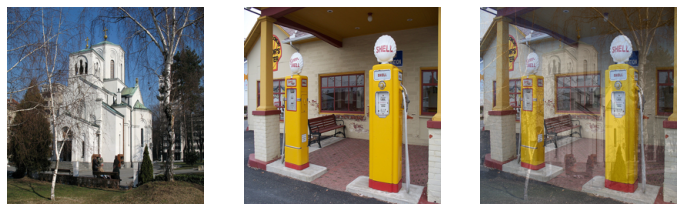

In [13]:
church = PILImage.create(get_image_files_sorted(path/'train'/'n03028079')[0])
gas = PILImage.create(get_image_files_sorted(path/'train'/'n03425413')[0])
church = church.resize((256,256))
gas = gas.resize((256,256))
tchurch = tensor(church).float() / 255.
tgas = tensor(gas).float() / 255.

_,axs = plt.subplots(1, 3, figsize=(12,4))
show_image(tchurch, ax=axs[0]);
show_image(tgas, ax=axs[1]);
show_image((0.3*tchurch + 0.7*tgas), ax=axs[2]);

Третье изображение строится путем сложения 0,3 раза первого умноженного на 0,3 и второго умноженного на 0,7. В этом примере должна ли модель предсказывать "церковь"или" заправочную станцию"? Правильный ответ-30% церкви и 70% бензоколонки, так как именно это мы получим, если возьмем линейную комбинацию OHE(one-hot-encoded) целей . Например, предположим, что у нас есть 10 классов, и "церковь" представлена индексом 2, а "заправочная станция" представлена индексом 7, тогда их OHE значение:
```
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0] and [0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
```
Итак, наша конечный результат:
```
[0, 0, 0.3, 0, 0, 0, 0, 0.7, 0, 0]
```
Все это делается для нас внутри fastai, добавляя обратный вызов нашему *Learner.Callbacks* - это то, что происходит внутри fastai для внедрения пользовательского поведения в цикл обучения (например, график скорости обучения или обучение со смешанной точностью). Мы узнаем все о обратных вызовах, в том числе о том, как сделать свой собственный, дальше.

Вот как мы обучаем модель с помощью Mixup:

```python
model = xresnet50()
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), 
                metrics=accuracy, cbs=MixUp)
learn.fit_one_cycle(5, 3e-3)
```

Что происходит, когда мы обучаем модель с данными, которые "перемешаны" таким образом? Очевидно, что тренироваться будет сложнее, потому что труднее увидеть, что находится в каждом изображении. И модель должна предсказать две метки на изображение, а не только одну, а также выяснить, насколько каждая из них взвешена. Однако переобучение кажется менее вероятной проблемой, потому что мы не показываем одно и то же изображение в каждую эпоху, а вместо этого показываем случайную комбинацию двух изображений.

Mixup требует гораздо больше эпох для тренировки, чтобы получить лучшую точность, по сравнению с другими подходами к увеличению, которые мы видели. Вы можете попробовать обучить Imagenette с помощью Mixup и без него, используя examples/train_imagenette.py скрипт в репо fastai. На момент написания статьи таблица лидеров в репо Imagenette показывает, что Mixup используется для всех лидирующих результатов для тренировок >80 эпох, а для меньшего количества эпох Mixup не используется. Это также согласуется с нашим опытом использования Mixup.

Одна из причин того, что Mixup настолько увлекателен, заключается в том, что он может быть применен к другим типам данных, кроме фотографий. На самом деле, некоторые люди даже показали хорошие результаты, используя Mixup на активациях внутри своих моделей, а не только на входах—это позволяет использовать Mixup для NLP и других типов данных.

Есть еще одна тонкая проблема, с которой Mixup справляется для нас, а именно то, что на самом деле невозможно с моделями, которые мы видели раньше, чтобы наша потеря когда-либо была абсолютной. Проблема в том, что наши метки равны 1 и 0, но выходы softmax и sigmoid никогда не могут равняться 1 или 0. Это означает, что обучение нашей модели подталкивает наши активации все ближе к этим значениям, так что чем больше эпох мы делаем, тем более экстремальными становятся наши активации.

С Mixup у нас больше нет этой проблемы, потому что наши метки будут точно равны 1 или 0, если мы случайно "смешаемся" с другим изображением того же класса. В остальное время наши метки будут представлять собой линейную комбинацию, такую как 0,7 и 0,3, которые мы получили в примере с церковью и бензоколонкой ранее.

Однако одна из проблем заключается в том, что Mixup "случайно" делает метки больше 0 или меньше 1. То есть мы не говорим явно нашей модели, что хотим изменить цели таким образом. Таким образом, если мы хотим сделать метки ближе или дальше от 0 и 1, мы должны изменить количество в Mixup — что также изменяет количество приращения данных, что может быть не тем, что мы хотим. Однако есть способ справиться с этим более непосредственно, а именно использовать сглаживание меток.

## Сглаживание меток

Модель обучена возвращать 0 для всех категорий, кроме одной, для которой она обучена возвращать 1. Это поощряет переобучение и дает вам во время вывода модель, которая не даст значимых вероятностей: она всегда будет говорить 1 для предсказанной категории, даже если она не слишком уверена, просто потому, что она была обучена таким образом.

Это может стать очень вредным, если ваши данные не будут точно размечены.

Вместо этого мы могли бы заменить все наши 1 на число немного меньше 1, а наши 0 на число немного больше 0, а затем обучаться. Это называется сглаживанием меток. Поощряя вашу модель быть менее уверенной, сглаживание меток сделает ваше обучение более надежным, даже если есть неверно помеченные данные. Результатом будет модель, которая лучше делает выводы.